Week 1: Data Download and Feature Engineering

In this notebook, we implement Week 1 of the “Generative Forecasting Meets Adaptive Allocation” project. We will download daily OHLCV data for 10 US stocks over the last 10 years, and compute rolling features needed for modeling. The main steps are:

Fixed date range: 2015-08-01 → 2025-08-01

Download OHLCV with yfinance (auto_adjust=True)

Enforce data checks: no duplicates, tz-naive index, business-day alignment, NaN heatmap

Store data in canonical schema (ticker, field)

Compute daily returns from adjusted closes

Compute rolling features:

20-day & 60-day volatility

20-day & 60-day momentum

20-day pairwise correlations

Validate causality with unit-style tests (no look-ahead)

Save aligned prices, returns, and features for Week

1. Preliminary System check First 

In [2]:
import sys

# Check current Python environment
print("Current Python executable:", sys.executable)

# Install yfinance in the same environment Jupyter is using
!{sys.executable} -m pip install yfinance --quiet

# Confirm installation
!{sys.executable} -m pip show yfinance


Current Python executable: c:\Users\Krish\anaconda3\python.exe
Name: yfinance
Version: 0.2.65
Summary: Download market data from Yahoo! Finance API
Home-page: https://github.com/ranaroussi/yfinance
Author: Ran Aroussi
Author-email: ran@aroussi.com
License: Apache
Location: c:\Users\Krish\anaconda3\Lib\site-packages
Requires: beautifulsoup4, curl_cffi, frozendict, multitasking, numpy, pandas, peewee, platformdirs, protobuf, pytz, requests, websockets
Required-by: 


1. Imports and configs

In [1]:
# --- Cell 1: Config, metadata, helpers ---

import pandas as pd
import numpy as np
import itertools
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

START_DATE = "2015-08-01"   # YYYY-MM-DD
END_DATE   = "2025-08-01"   # YYYY-MM-DD

TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "NVDA", "JPM", "JNJ", "XOM", "WMT"]

TICKER_META = {
    "AAPL": {"name": "Apple Inc.",              "sector": "Information Technology"},
    "MSFT": {"name": "Microsoft Corporation",   "sector": "Information Technology"},
    "AMZN": {"name": "Amazon.com, Inc.",        "sector": "Consumer Discretionary"},
    "GOOGL":{"name": "Alphabet Inc. (Class A)", "sector": "Communication Services"},
    "META": {"name": "Meta Platforms, Inc.",    "sector": "Communication Services"},
    "NVDA": {"name": "NVIDIA Corporation",      "sector": "Information Technology"},
    "JPM":  {"name": "JPMorgan Chase & Co.",    "sector": "Financials"},
    "JNJ":  {"name": "Johnson & Johnson",       "sector": "Health Care"},
    "XOM":  {"name": "Exxon Mobil Corporation", "sector": "Energy"},
    "WMT":  {"name": "Walmart Inc.",            "sector": "Consumer Staples"},
}
meta_df = pd.DataFrame(TICKER_META).T
meta_df


,name,sector
AAPL,Apple Inc.,Information Technology
MSFT,Microsoft Corporation,Information Technology
AMZN,"Amazon.com, Inc.",Consumer Discretionary
GOOGL,Alphabet Inc. (Class A),Communication Services
META,"Meta Platforms, Inc.",Communication Services
NVDA,NVIDIA Corporation,Information Technology
JPM,JPMorgan Chase & Co.,Financials
JNJ,Johnson & Johnson,Health Care
XOM,Exxon Mobil Corporation,Energy
WMT,Walmart Inc.,Consumer Staples


2. Download OHLCV

In [2]:
# --- Cell 2: Download OHLCV (auto-adjusted) and canonicalize schema ---

raw = yf.download(
    TICKERS,
    start=START_DATE,
    end=END_DATE,
    interval="1d",
    auto_adjust=True,      
    group_by="ticker",     
    progress=False,
    threads=True,
)

# Ensure DatetimeIndex is tz-naive, sorted, unique
idx = raw.index
if getattr(idx, "tz", None) is not None:
    raw.index = idx.tz_convert(None)
raw = raw.sort_index()
assert raw.index.is_monotonic_increasing, "Index not increasing"
assert raw.index.is_unique, "Duplicate timestamps in raw index"

# Build canonical prices DataFrame with MultiIndex columns: (ticker, field)
# Only keep standard fields to stay consistent as we add features later.
fields = ["Open", "High", "Low", "Close", "Volume"]
frames = []
for tic in TICKERS:
    # Some tickers can be missing if delisted on a portion; guard:
    if tic not in raw.columns.get_level_values(0):
        raise KeyError(f"Ticker {tic} missing from download.")
    sub = raw[tic][fields].copy()
    sub.columns = pd.MultiIndex.from_product([[tic], sub.columns], names=["ticker", "field"])
    frames.append(sub)

prices = pd.concat(frames, axis=1).sort_index(axis=1)
prices.index.name = "date"
prices.head()



ticker           AAPL                                                   AMZN  \
field           Close       High        Low       Open     Volume      Close   
date                                                                           
2015-08-03  26.496555  27.420489  26.290738  27.181116  279904000  26.751499   
2015-08-04  25.646442  26.331003  25.335482  26.268364  496554400  26.594999   
2015-08-05  25.816467  26.272842  25.078214  25.268370  397250400  26.850500   
2015-08-06  25.872652  26.180527  25.645680  26.061422  211612000  26.473000   
2015-08-07  25.960299  26.124349  25.731079  25.749058  154681600  26.131001   

ticker                                                 ...        WMT  \
field            High        Low       Open    Volume  ...      Close   
date                                                   ...              
2015-08-03  27.021999  26.468000  26.872499  60284000  ...  19.791973   
2015-08-04  26.847500  26.458000  26.484501  58692000  ...  19.811163   
2015-08-05  26.957001  26.705999  26.940001  57788000  ...  20.294289   
2015-08-06  27.136999  26.375999  26.965000  76410000  ...  20.095522   
2015-08-07  26.473000  25.910500  26.458000  79384000  ...  19.670368   

ticker                                                       XOM             \
field            High        Low       Open    Volume      Close       High   
date                                                                          
2015-08-03  19.846814  19.698745  19.698745  15395400  49.907009  50.463238   
2015-08-04  19.961975  19.723420  19.857778  17620200  49.337990  50.258643   
2015-08-05  20.343983  19.946434  19.985085  26147400  49.337990  50.015695   
2015-08-06  20.258406  20.059632  20.250126  19103100  49.926193  50.034885   
2015-08-07  20.106567  19.648282  20.073439  23392500  49.120625  49.849474   

ticker                                      
field             Low       Open    Volume  
date                                        
2015-08-03  49.632092  50.316187  15767700  
2015-08-04  49.184549  49.791922  18874400  
2015-08-05  49.165370  49.785532  16544400  
2015-08-06  49.171775  49.190954  13005200  
2015-08-07  48.986363  49.580951  12187600  

[5 rows x 50 columns]

3. Assertions + NaN heatmap 

✓ Missing Close data within tolerance


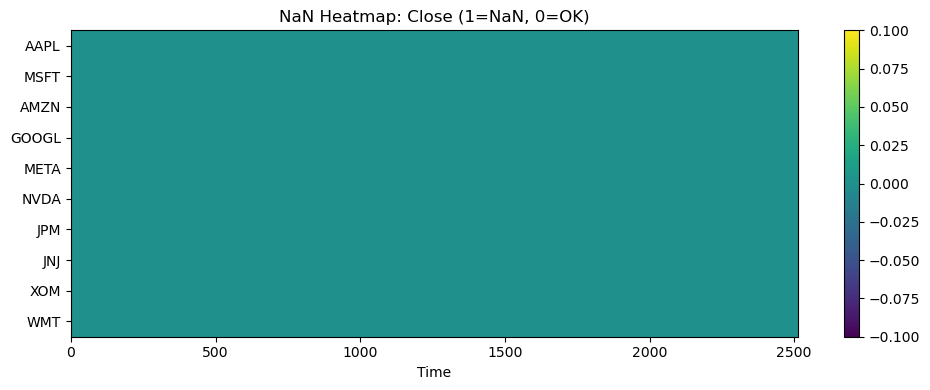

In [ ]:
# --- Cell 3: Assertions + NaN heatmap 

# 0) date range coverage
start, end = pd.to_datetime(START_DATE), pd.to_datetime(END_DATE)
assert prices.index.min() >= start - pd.Timedelta(days=3), "Start earlier than expected"
assert prices.index.max() <= pd.to_datetime(END_DATE), "End later than expected"

# 1) no duplicates & tz-naive already ensured
assert prices.index.is_unique, "Duplicate dates in prices"
assert getattr(prices.index, "tz", None) is None, "Index still timezone-aware"

# 2) trading-day alignment (subset of a business-day calendar)
bcal = pd.bdate_range(start=START_DATE, end=END_DATE, freq="C")  # business days
# Trading days must be subset of business calendar
missing_from_bcal = prices.index.difference(bcal)
assert len(missing_from_bcal) == 0, f"Found {len(missing_from_bcal)} non-business timestamps"

# 3) basic missingness checks
# allow some NaNs due to ticker symbol changes (FB->META). Flag if >2% missing on Close per ticker
close_cols = prices.loc[:, (slice(None), "Close")]
miss_report = close_cols.isna().mean().sort_values(ascending=False)
bad = miss_report[miss_report > 0.02]
if not bad.empty:
    print("More than 2% missing Close data for:", list(bad.index.get_level_values(0).unique()))
else:
    print("Missing Close data within tolerance")

# 4) quick NaN heatmap across Close prices (rows=dates; cols=tickers)
# (This is a small visualization to eyeball holes before feature calc.)
heat = close_cols.isna().astype(int)
plt.figure(figsize=(10, 4))
plt.imshow(heat.T, aspect="auto", interpolation="nearest")
plt.yticks(range(len(TICKERS)), TICKERS)
plt.xlabel("Time")
plt.title("NaN Heatmap: Close (1=NaN, 0=OK)")
plt.colorbar()
plt.tight_layout()
plt.show()


4. Adj-close matrix & returns with canonical schema

In [4]:
# --- Cell 4: Adj-close matrix & returns with canonical schema ---

# With auto_adjust=True, "Close" is adjusted
adj_close = prices.loc[:, (slice(None), "Close")].copy()
adj_close.columns = adj_close.columns.set_names(["ticker", "field"])

# Returns: keep MultiIndex columns (ticker, "ret")
rets = adj_close.copy()
for tic in TICKERS:
    s = adj_close[(tic, "Close")].pct_change()
    rets[(tic, "ret")] = s
# keep only ret columns, drop Close
rets = rets.loc[:, (slice(None), "ret")].copy().dropna(how="all")
rets.columns = rets.columns.set_names(["ticker", "field"])

print("prices shape:", prices.shape)
print("adj_close shape:", adj_close.shape)
print("rets shape:", rets.shape)



prices shape: (2514, 50)
adj_close shape: (2514, 10)
rets shape: (2513, 10)


5. Causal rolling features in canonical schema

In [5]:
# --- Cell 5: Causal rolling features in canonical schema ---

VOL_WINS = [20, 60]
MOM_WINS = [20, 60]
CORR_WIN = 20

# Helper to rename with (ticker, feature_name)
def _rename_feature(df, ticker, featname):
    df = df.copy()
    df.name = None
    df = df.to_frame()
    df.columns = pd.MultiIndex.from_product([[ticker], [featname]], names=["ticker", "field"])
    return df

# Volatility (rolling std of daily returns)
vol_parts = []
for tic in TICKERS:
    sret = rets[(tic, "ret")]
    for w in VOL_WINS:
        vol = sret.rolling(w, min_periods=w).std()  # CAUSAL: uses [t-w+1, t]
        vol_parts.append(_rename_feature(vol, tic, f"vol{w}"))

vol_df = pd.concat(vol_parts, axis=1).sort_index(axis=1)

# Momentum (P_t / P_{t-w} - 1), strictly uses lagged price (no future)
mom_parts = []
for tic in TICKERS:
    p = adj_close[(tic, "Close")]
    for w in MOM_WINS:
        mom = (p / p.shift(w)) - 1.0
        mom_parts.append(_rename_feature(mom, tic, f"mom{w}"))

mom_df = pd.concat(mom_parts, axis=1).sort_index(axis=1)

# 20-day pairwise correlations on returns
corr_cols = []
for s1, s2 in itertools.combinations(TICKERS, 2):
    # rolling corr is causal by definition (uses window up to t)
    corr = rets[(s1, "ret")].rolling(CORR_WIN, min_periods=CORR_WIN).corr(rets[(s2, "ret")])
    # store under a "PAIR" pseudo-ticker to keep schema consistent
    pair_name = f"{s1}_{s2}_corr{CORR_WIN}"
    corr_cols.append(_rename_feature(corr, "PAIR", pair_name))

corr_df = pd.concat(corr_cols, axis=1).sort_index(axis=1)

print("vol_df:", vol_df.shape, "mom_df:", mom_df.shape, "corr_df:", corr_df.shape)


vol_df: (2513, 20) mom_df: (2514, 20) corr_df: (2513, 45)


6. Assemble features & align master frames

In [6]:
# --- Cell 6: Assemble features & align master frames ---

features = pd.concat([vol_df, mom_df, corr_df], axis=1)
features = features.dropna(how="any")  # drop rows without full feature set

# Align prices/returns to feature index for downstream tasks
idx = features.index
prices_aligned = prices.loc[idx]
rets_aligned   = rets.loc[idx]
adj_close_aligned = adj_close.loc[idx]

print("features:", features.shape)
print("prices_aligned:", prices_aligned.shape)
print("rets_aligned:", rets_aligned.shape)
print("adj_close_aligned:", adj_close_aligned.shape)


features: (2454, 85)
prices_aligned: (2454, 50)
rets_aligned: (2454, 10)
adj_close_aligned: (2454, 10)


7. Causality Checks

In [ ]:
# --- Cell 7 : Causality checks using aligned frames ---

import numpy as np

rng = np.random.default_rng(42)

# Align feature components to the exact feature index used downstream
idx = features.index
vol_df_aligned = vol_df.loc[idx]
mom_df_aligned = mom_df.loc[idx]
rets_aligned   = rets.loc[idx]
adj_close_aligned = adj_close.loc[idx]

def check_vol_causality(ticker, window, nchecks=5):
    sret = rets_aligned[(ticker, "ret")]
    stored_series = vol_df_aligned[(ticker, f"vol{window}")]
    valid_pos = np.where(~stored_series.isna())[0]
    if len(valid_pos) == 0:
        return True
    ok = True
    for _ in range(min(nchecks, len(valid_pos))):
        i = int(rng.choice(valid_pos))
        # recompute using the same window *positions* on the aligned series
        start = i - window + 1
        if start < 0:
            continue
        window_slice = sret.iloc[start:i+1]
        recomputed = window_slice.std(ddof=1)  # pandas default; explicit for clarity
        stored = stored_series.iloc[i]
        if not np.isclose(recomputed, stored, rtol=1e-6, atol=1e-12):
            print(f"VOL causality mismatch {ticker} w={window} at {stored_series.index[i]}: {stored} vs {recomputed}")
            ok = False
    return ok

def check_mom_causality(ticker, window, nchecks=5):
    price = adj_close_aligned[(ticker, "Close")]
    stored_series = mom_df_aligned[(ticker, f"mom{window}")]
    valid_pos = np.where(~stored_series.isna())[0]
    if len(valid_pos) == 0:
        return True
    ok = True
    for _ in range(min(nchecks, len(valid_pos))):
        i = int(rng.choice(valid_pos))
        if i - window < 0:
            continue
        recomputed = (price.iloc[i] / price.iloc[i - window]) - 1.0
        stored = stored_series.iloc[i]
        if not np.isclose(recomputed, stored, rtol=1e-10, atol=1e-12):
            print(f"MOM causality mismatch {ticker} w={window} at {stored_series.index[i]}: {stored} vs {recomputed}")
            ok = False
    return ok

vol_ok = all(check_vol_causality(t, w) for t in TICKERS for w in VOL_WINS)
mom_ok = all(check_mom_causality(t, w) for t in TICKERS for w in MOM_WINS)
assert vol_ok and mom_ok, "Causality checks failed"
print("✓ Causality checks passed (vol & mom) with aligned windows.")


✓ Causality checks passed (vol & mom) with aligned windows.


Save artifacts for Week-2

In [9]:
# --- Cell 8: Final integrity assertions & save ---

# Shape consistency
assert features.index.equals(prices_aligned.index)
assert features.index.equals(rets_aligned.index)
assert features.index.equals(adj_close_aligned.index)

# Column schema checks (MultiIndex with levels: ticker, field)
for df, name in [(prices_aligned, "prices"), (adj_close_aligned, "adj_close"),
                 (rets_aligned, "rets"), (features, "features")]:
    assert isinstance(df.columns, pd.MultiIndex), f"{name} columns are not MultiIndex"
    assert df.columns.names == ["ticker", "field"], f"{name} columns names mismatch"

# Save
prices_aligned.to_parquet("prices_week1.parquet")
adj_close_aligned.to_parquet("adj_close_week1.parquet")
rets_aligned.to_parquet("returns_week1.parquet")
features.to_parquet("features_week1.parquet")

# CSV (optional)
features.to_csv("features_week1.csv")
prices_aligned.to_csv("prices_week1.csv")
rets_aligned.to_csv("returns_week1.csv")
adj_close_aligned.to_csv("adj_close_week1.csv")

print(" Week 1 artifacts saved.")


 Week 1 artifacts saved.
